In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CosineSimilarity

from gw_grb_correlation.Fermi.data_preprocessing import create_dataframe_and_name_column_from_data_files
from gw_grb_correlation.Fermi.util import process_data

In [ ]:
# Load data
fermi_data = create_dataframe_and_name_column_from_data_files(data_type='fermi')

# List of detectors
detectors = [f"n{i}" for i in range(10)] + ["na", "nb", "b0", "b1"]

# Define input columns
PH_CNT_columns = [f"{detector}_PH_CNT" for detector in detectors]
TRIG_columns = [f"{detector}_TRIG" for detector in detectors]
Orientation_columns = ['QSJ_1', 'QSJ_2', 'QSJ_3', 'QSJ_4']
fermi_data[PH_CNT_columns] = np.array(fermi_data[PH_CNT_columns].values.astype(np.float64)) * np.array(fermi_data[TRIG_columns].values.astype(np.float64))

input_columns = Orientation_columns + TRIG_columns + PH_CNT_columns

X_scaled, X_train_scaled, X_test_scaled, y, y_train, y_test = process_data(fermi_data, input_columns)

In [ ]:
from gw_grb_correlation.Fermi.util import cosine_similarity_loss
# Define model with Dropout
Dropout_rate = 0.05
model_with_orientation = Sequential([
    Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dropout(Dropout_rate),
    Dense(512, activation='relu'),
    Dropout(Dropout_rate),
    Dense(512, activation='relu'),
    Dropout(Dropout_rate),
    Dense(3, activation=None),  # Output layer, no activation
])


# Compile model
model_with_orientation.compile(
    optimizer=Adam(learning_rate=0.00002),
    loss=cosine_similarity_loss,
    metrics=[CosineSimilarity(name='cosine_similarity')]
)

C:\Users\colon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - cosine_similarity: -0.0010 - loss: 0.0010 - val_cosine_similarity: 0.0144 - val_loss: -0.0144
Epoch 2/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - cosine_similarity: 0.0082 - loss: -0.0082 - val_cosine_similarity: 0.0511 - val_loss: -0.0511
Epoch 3/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - cosine_similarity: 0.0756 - loss: -0.0756 - val_cosine_similarity: 0.0823 - val_loss: -0.0823
Epoch 4/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - cosine_similarity: 0.1097 - loss: -0.1097 - val_cosine_similarity: 0.1066 - val_loss: -0.1066
Epoch 5/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - cosine_similarity: 0.1423 - loss: -0.1423 - val_cosine_similarity: 0.1236 - val_loss: -0.1236
Epoch 6/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - cosine_similarity: 0.1524 - loss: -0.1524 - val_cosine_similarity: 0.1448 - val_loss: -0.1448
Epoch 7/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - cosine_similarity: 0.1911 - loss: -0.1911 - val_cos

Model trained and saved as model_with_orientation.h5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - cosine_similarity: 0.9141 - loss: -0.9141 
Test Loss: -0.9058
Cosine Similarity: 0.9058
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Mean norm of predicted vectors: 0.2696196
Standard deviation of norms: 0.06525564


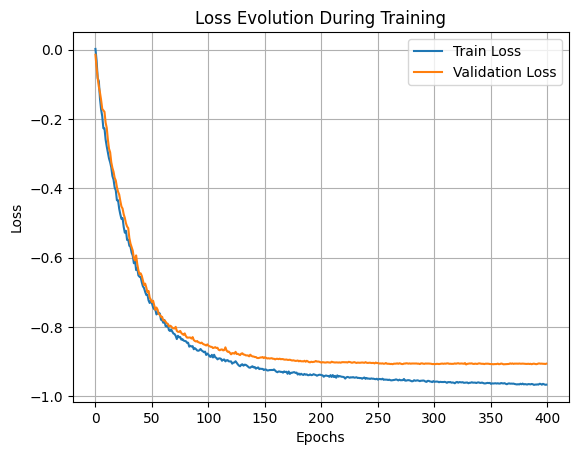

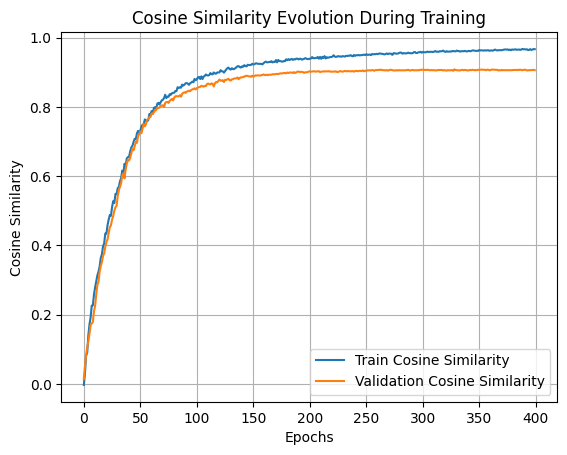

In [4]:
# Train model
history = model_with_orientation.fit(
    X_train_scaled, y_train,
    epochs=400,
    batch_size=16,
    validation_data=(X_test_scaled, y_test)
)

model_with_orientation_path = "model_with_orientation.h5"
# Save the trained model
model_with_orientation.save(model_with_orientation_path)
print(f"Model trained and saved as {model_with_orientation_path}")

from gw_grb_correlation.Fermi.visualization import evaluate_model_and_plot_accurracy
train_acc_full_data, val_acc_full_data = evaluate_model_and_plot_accurracy(model_with_orientation, history, X_test_scaled, y_test)

In [5]:
from gw_grb_correlation.Fermi.util import convert_cartesian_to_spherical
predictions = model_with_orientation.predict(X_scaled)

RA_DEC_predictions = np.array([convert_cartesian_to_spherical(pred) for pred in predictions])
fermi_predict_data = fermi_data.copy()

fermi_predict_data['RA'] = RA_DEC_predictions[:, 0]
fermi_predict_data['DEC'] = RA_DEC_predictions[:, 1]

fermi_predict_data.to_csv("fermi_predict_data.csv", index=False)

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


In [6]:
from gw_grb_correlation.Fermi.util import filtering, duration
# Filter out short GRB data
short_GRB_data = filtering(fermi_predict_data, criteria={'T90': lambda x: x <= 2.1})

# Calculate the duration (difference between max TSTOP and min TSTART) and count the short GRB event number
duration_short_GRB = duration(short_GRB_data)
event_num_short_GRB = len(short_GRB_data)

# Calculate the average occurrence rate (events per unit of time)
average_occurrence_rate = event_num_short_GRB / duration_short_GRB

# Print the results
print(f"Number of events: {event_num_short_GRB}")
print(f"Total duration: {duration_short_GRB} seconds")
print(f"Average occurrence rate: {average_occurrence_rate} events per second")

Number of events: 354
Total duration: 323245732.96269 seconds
Average occurrence rate: 1.0951420665492892e-06 events per second


In [8]:
from gw_grb_correlation.Fermi.util import read_GW_data, remove_duplicate_times_in_gw_data, compare_time_within_range
# Load GW data
gw_data = read_GW_data(f"./gw_data/totalgwdata.csv")
gw_times = remove_duplicate_times_in_gw_data(gw_data)

# Find matched GRB-GW event pairs
match = compare_time_within_range(short_GRB_data, gw_times, time_range_seconds=86400*3)
filtered_gw_events = gw_data[gw_data['times'].isin(match['gw_time'])]
match.to_csv("GRB_GW_event_pairs_predict.csv", index=False)
filtered_gw_events.to_csv("Filtered_GW_events_predict.csv", index=False)

Data from ./gw_data/totalgwdata.csv loaded successfully.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2418227 entries, 0 to 2418226
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Unnamed: 0  int64  
 1   ra          float64
 2   dec         float64
 3   times       float64
 4   weights     float64
dtypes: float64(4), int64(1)
memory usage: 92.2 MB
None
   Unnamed: 0        ra       dec         times   weights
0           0  1.891867 -1.250744  1.126259e+09  0.000024
1           1  1.254342 -1.228042  1.126259e+09  0.000024
2           2  1.666787 -1.279668  1.126259e+09  0.000024
3           3  1.863250 -1.261367  1.126259e+09  0.000024
4           4  0.994238 -1.036272  1.126259e+09  0.000024
Number of unique times after applying threshold: 91
First few unique times:
               times                          date
0       1.126259e+09 2015-09-14 09:51:02.000000000
44173   1.128679e+09 2015-10-12 09:55:00.000000000
79620   1.135136e+09 20

C:\Users\colon\OneDrive\桌面\TheoryWork\group_project_2025\gw_grb_correlation\Fermi\util.py:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fermi_data['ALIGNED_SEC'] = pd.to_numeric(fermi_data['TSTART'], errors='coerce')
C:\Users\colon\OneDrive\桌面\TheoryWork\group_project_2025\gw_grb_correlation\Fermi\util.py:225: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fermi_data['ALIGNED_SEC'] = fermi_data['ALIGNED_SEC'] + (fermi_start_date - pd.Timestamp("1980-01-01")).total_seconds()


Found 44 matches within 259200 seconds.


In [9]:
model_with_orientation.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,003,403 (3.83 MB)

 Trainable params: 334,467 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 668,936 (2.55 MB)

In [10]:
# This time, we test model trained without spacecraft orientation data
# Load data again
fermi_data = create_dataframe_and_name_column_from_data_files(data_type='fermi')
input_columns = TRIG_columns + PH_CNT_columns # No Spacecraft Orientation

X_scaled, X_train_scaled, X_test_scaled, y, y_train, y_test = process_data(fermi_data, input_columns)

In [11]:
# Define model with Dropout
Dropout_rate = 0.05
model_without_orientation = Sequential([
    Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dropout(Dropout_rate),
    Dense(512, activation='relu'),
    Dropout(Dropout_rate),
    Dense(512, activation='relu'),
    Dropout(Dropout_rate),
    Dense(3, activation=None),  # Output layer, no activation
])

# Compile model
model_without_orientation.compile(
    optimizer=Adam(learning_rate=0.00002),
    loss=cosine_similarity_loss,
    metrics=[CosineSimilarity(name='cosine_similarity')]
)

C:\Users\colon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - cosine_similarity: -0.0062 - loss: 0.0062 - val_cosine_similarity: 0.0271 - val_loss: -0.0271
Epoch 2/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - cosine_similarity: 0.0583 - loss: -0.0583 - val_cosine_similarity: 0.0670 - val_loss: -0.0670
Epoch 3/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - cosine_similarity: 0.0868 - loss: -0.0868 - val_cosine_similarity: 0.0914 - val_loss: -0.0914
Epoch 4/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - cosine_similarity: 0.1101 - loss: -0.1101 - val_cosine_similarity: 0.0943 - val_loss: -0.0943
Epoch 5/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - cosine_similarity: 0.1229 - loss: -0.1229 - val_cosine_similarity: 0.1075 - val_loss: -0.1075
Epoch 6/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - cosine_similarity: 0.1347 - loss: -0.1347 - val_cosine_similarity: 0.1349 - val_loss: -0.1349
Epoch 7/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - cosine_similarity: 0.1583 - loss: -0.1583 - val_cos

Model trained and saved as model_without_orientation.h5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - cosine_similarity: 0.2479 - loss: -0.2479 
Test Loss: -0.2199
Cosine Similarity: 0.2199
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Mean norm of predicted vectors: 0.113668524
Standard deviation of norms: 0.35897535


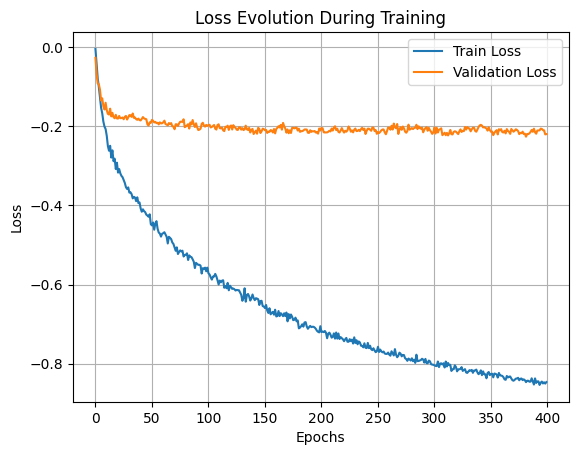

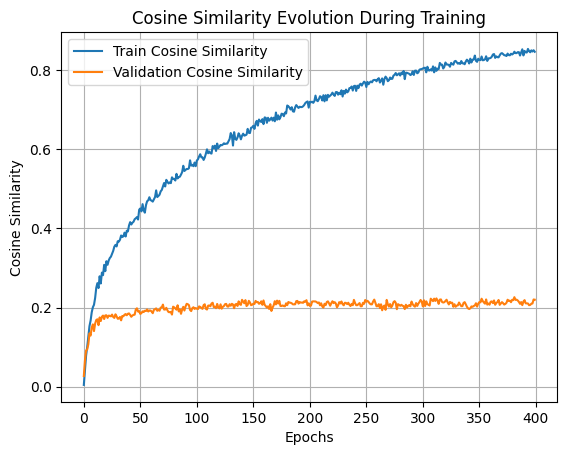

In [12]:
# Train model
history_without_orientation = model_without_orientation.fit(
    X_train_scaled, y_train,
    epochs=400,
    batch_size=16,
    validation_data=(X_test_scaled, y_test)
)
model_without_orientation_path = "model_without_orientation.h5"
# Save the trained model
model_without_orientation.save(model_without_orientation_path)
print(f"Model trained and saved as {model_without_orientation_path}")

train_acc_no_ori, val_acc_no_ori = evaluate_model_and_plot_accurracy(model_without_orientation, history_without_orientation, X_test_scaled, y_test)

In [13]:
model_without_orientation.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │         3,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,001,867 (3.82 MB)

 Trainable params: 333,955 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 667,912 (2.55 MB)

In [14]:
# This time, we test model trained without trigger data
# Load data again
fermi_data = create_dataframe_and_name_column_from_data_files(data_type='fermi')
input_columns = Orientation_columns + PH_CNT_columns 

X_scaled, X_train_scaled, X_test_scaled, y, y_train, y_test = process_data(fermi_data, input_columns)

In [15]:
# Define model with Dropout
Dropout_rate = 0.05
model_without_trigger = Sequential([
    Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dropout(Dropout_rate),
    Dense(512, activation='relu'),
    Dropout(Dropout_rate),
    Dense(512, activation='relu'),
    Dropout(Dropout_rate),
    Dense(3, activation=None),  # Output layer, no activation
])

# Compile model
model_without_trigger.compile(
    optimizer=Adam(learning_rate=0.00002),
    loss=cosine_similarity_loss,
    metrics=[CosineSimilarity(name='cosine_similarity')]
)

C:\Users\colon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - cosine_similarity: -0.0146 - loss: 0.0146 - val_cosine_similarity: -0.0239 - val_loss: 0.0239
Epoch 2/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - cosine_similarity: 0.0495 - loss: -0.0495 - val_cosine_similarity: 0.0113 - val_loss: -0.0113
Epoch 3/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - cosine_similarity: 0.0801 - loss: -0.0801 - val_cosine_similarity: 0.0476 - val_loss: -0.0476
Epoch 4/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - cosine_similarity: 0.1137 - loss: -0.1137 - val_cosine_similarity: 0.0755 - val_loss: -0.0755
Epoch 5/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - cosine_similarity: 0.1407 - loss: -0.1407 - val_cosine_similarity: 0.0969 - val_loss: -0.0969
Epoch 6/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - cosine_similarity: 0.1763 - loss: -0.1763 - val_cosine_similarity: 0.1201 - val_loss: -0.1201
Epoch 7/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - cosine_similarity: 0.2474 - loss: -0.2474 - val_cos

Model trained and saved as model_without_trigger.h5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - cosine_similarity: 0.2064 - loss: -0.2064 
Test Loss: -0.1868
Cosine Similarity: 0.1868
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Mean norm of predicted vectors: 0.079274
Standard deviation of norms: 0.19353175


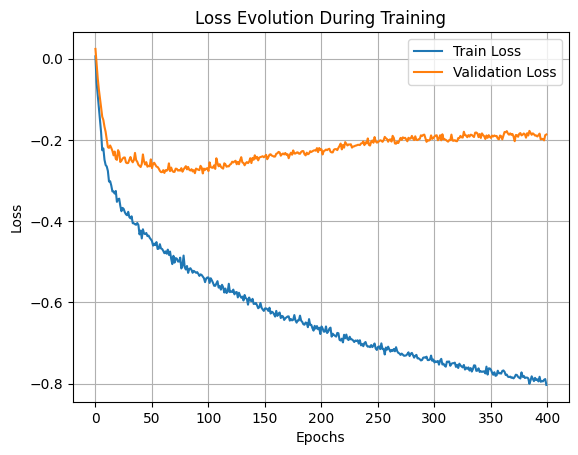

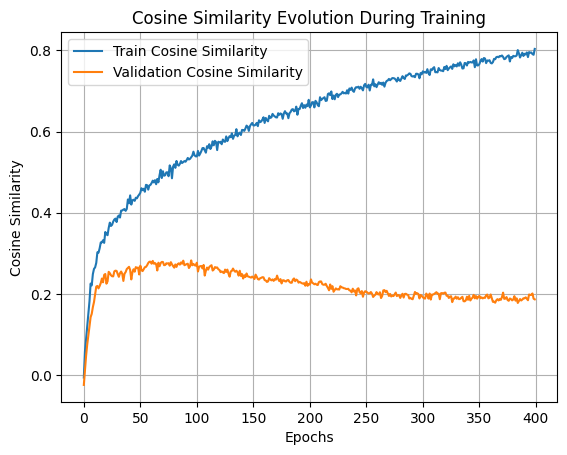

In [16]:
# Train model
history_without_trigger = model_without_trigger.fit(
    X_train_scaled, y_train,
    epochs=400,
    batch_size=16,
    validation_data=(X_test_scaled, y_test)
)
model_without_trigger_path = "model_without_trigger.h5"
# Save the trained model
model_without_trigger.save(model_without_trigger_path)
print(f"Model trained and saved as {model_without_trigger_path}")

train_acc_no_trig, val_acc_no_trig = evaluate_model_and_plot_accurracy(model_without_trigger, history_without_trigger, X_test_scaled, y_test)

In [17]:
model_without_trigger.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 128)            │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 998,027 (3.81 MB)

 Trainable params: 332,675 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 665,352 (2.54 MB)

In [18]:
# This time, we test model trained without photon count data
# Load data again
fermi_data = create_dataframe_and_name_column_from_data_files(data_type='fermi')
input_columns = Orientation_columns + TRIG_columns 

X_scaled, X_train_scaled, X_test_scaled, y, y_train, y_test = process_data(fermi_data, input_columns)

In [19]:
# Define model with Dropout
Dropout_rate = 0.05
model_without_pht_cnt = Sequential([
    Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dropout(Dropout_rate),
    Dense(512, activation='relu'),
    Dropout(Dropout_rate),
    Dense(512, activation='relu'),
    Dropout(Dropout_rate),
    Dense(3, activation=None),  # Output layer, no activation
])

# Compile model
model_without_pht_cnt.compile(
    optimizer=Adam(learning_rate=0.00002),
    loss=cosine_similarity_loss,
    metrics=[CosineSimilarity(name='cosine_similarity')]
)

C:\Users\colon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - cosine_similarity: -0.0036 - loss: 0.0036 - val_cosine_similarity: 0.0463 - val_loss: -0.0463
Epoch 2/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - cosine_similarity: 0.0481 - loss: -0.0481 - val_cosine_similarity: 0.0975 - val_loss: -0.0975
Epoch 3/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - cosine_similarity: 0.1087 - loss: -0.1087 - val_cosine_similarity: 0.1398 - val_loss: -0.1398
Epoch 4/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - cosine_similarity: 0.1472 - loss: -0.1472 - val_cosine_similarity: 0.1815 - val_loss: -0.1815
Epoch 5/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - cosine_similarity: 0.1816 - loss: -0.1816 - val_cosine_similarity: 0.2237 - val_loss: -0.2237
Epoch 6/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - cosine_similarity: 0.2488 - loss: -0.2488 - val_cosine_similarity: 0.3006 - val_loss: -0.3006
Epoch 7/400
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - cosine_similarity: 0.2804 - loss: -0.2804 - val_cos

Model trained and saved as model_without_pht_cnt.h5
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - cosine_similarity: 0.9266 - loss: -0.9266 
Test Loss: -0.9245
Cosine Similarity: 0.9245
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Mean norm of predicted vectors: 0.26746455
Standard deviation of norms: 0.054408144


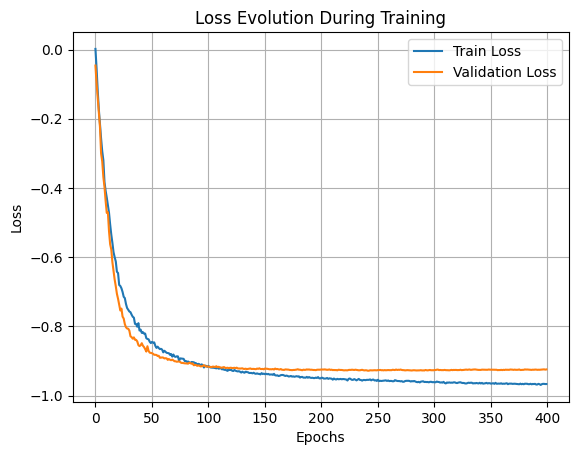

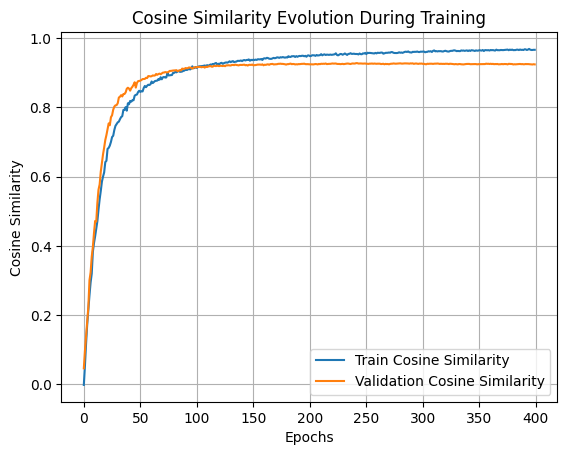

In [20]:
# Train model
history_without_pht_cnt = model_without_pht_cnt.fit(
    X_train_scaled, y_train,
    epochs=400,
    batch_size=16,
    validation_data=(X_test_scaled, y_test)
)
model_without_pht_cnt_path = "model_without_pht_cnt.h5"
# Save the trained model
model_without_pht_cnt.save(model_without_pht_cnt_path)
print(f"Model trained and saved as {model_without_pht_cnt_path}")

train_acc_no_pht_cnt, val_acc_no_pht_cnt = evaluate_model_and_plot_accurracy(model_without_pht_cnt, history_without_pht_cnt, X_test_scaled, y_test)

In [21]:
model_without_pht_cnt.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 998,027 (3.81 MB)

 Trainable params: 332,675 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 665,352 (2.54 MB)

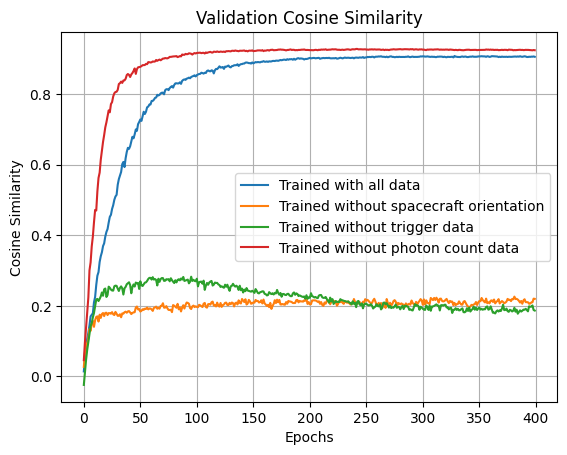

In [22]:
# Plot cosine similarity
plt.plot(val_acc_full_data, label='Trained with all data')
plt.plot(val_acc_no_ori, label='Trained without spacecraft orientation')
plt.plot(val_acc_no_trig, label='Trained without trigger data')
plt.plot(val_acc_no_pht_cnt, label='Trained without photon count data')
plt.xlabel('Epochs')
plt.ylabel('Cosine Similarity')
plt.title('Validation Cosine Similarity')
plt.legend()
plt.grid(True)
plt.show()